In [63]:
import networkExpansionPy.lib as ne
from scipy.sparse import csr_matrix
import numpy as np
from random import sample
import pandas as pd

#from copy import copy, deepcopy
import random
import seaborn as sns
from matplotlib_venn import venn2

In [85]:
metabolism = ne.GlobalMetabolicNetwork()
#metabolism.pruneUnbalancedReactions()
#metabolism.pruneInconsistentReactions()
#metabolism.set_ph(7.0)
metabolism.convertToIrreversible()

oxygen_dependent_rxns = metabolism.network[metabolism.network.cid.isin(['C00007'])].rn.unique().tolist()
o2_independent_rxns = [x for x in metabolism.network.rn.unique().tolist() if x not in oxygen_dependent_rxns]

# only keep anaerobic reactions
metabolism.subnetwork(o2_independent_rxns)
#metabolism.setMetaboliteBounds(ub=1e-1,lb=1e-6)
#metabolism.pruneThermodynamicallyInfeasibleReactions(keepnan=False)

In [168]:
#mm = ne.GlobalMetabolicNetwork()
#metabolism.pruneUnbalancedReactions()
#metabolism.pruneInconsistentReactions()
#metabolism.set_ph(7.0)

#mm.convertToIrreversible()

In [86]:
len(metabolism.network['rn'].unique().tolist())

7926

In [87]:
metabolism.network

,cid,rn,direction,s
0,C00001,R00002,forward,-16
1,C00002,R00002,forward,-16
2,C00008,R00002,forward,16
3,C00009,R00002,forward,16
4,C00138,R00002,forward,-8
...,...,...,...,...
40147,C15683,R10874,reverse,1
40155,C00363,R10876,reverse,-1
40156,C11911,R10876,reverse,1
40157,C15684,R10876,reverse,-1


In [65]:
# define seed compounds
cpds = pd.read_csv('/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/assets/compounds/seeds.csv')
cpds['CID'] = cpds['CID'].apply(lambda x: x.strip())

In [66]:
len(cpds["Name"].tolist())

44

In [67]:
rules = pd.read_csv('/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/assets/ecode/cath_code_rule.keggRxn.Jan2020.csv')

In [68]:
rules

,ec_3l,cath_code_rule,rn
0,1.1.1,1.1,R07105
1,1.1.1,1.1,R00623
2,1.1.1,1.1,R00754
3,1.1.1,1.1,R02124
4,1.1.1,1.1,R02878
...,...,...,...
235888,7.2.1,2.40_3.40,R09739
235889,7.2.4,1.20_3.90,R09509
235890,7.2.4,1.20_3.90,R12212
235891,7.2.4,1.20_3.90,R03028


In [69]:
grxns = set(metabolism.network.rn.unique().tolist())
frxns = set(rns)
subsets = (len(grxns - frxns), len(frxns - grxns), len(grxns.intersection(frxns)))

Text(0.5, 1.0, 'KEGG reactions')

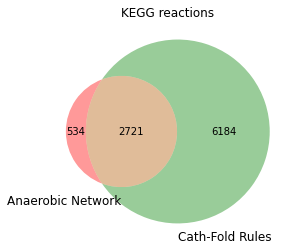

In [70]:
venn2(subsets = subsets,set_labels={'Anaerobic Network','Cath-Fold Rules'})
plt.title('KEGG reactions')

In [ ]:
rns = rules.rn.unique().tolist()
seed_set = cpds['CID'].unique().tolist()

In [71]:
m = metabolism.copy()
#m.subnetwork(rns)
#m.seedSet = seed_set
ne_cpds,ne_rxns = m.expand(seed_set)

/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


In [75]:
codes =  rules['cath_code_rule'].apply(lambda x: set(x.split('_')))
rules['cath_sets']= rules['cath_code_rule'].apply(lambda x: set(x.split('_')))

cath_codes = [item for sublist in codes for item in sublist]
cath_codes = list(set(cath_codes))

def rule2rn(foldSet,x):
    if x.issubset(foldSet):
        return True
    else:
        return False
    
def folds2rn(rules_sub,foldSet):
    rules_sub['rn_feasible'] = rules_sub['cath_sets'].apply(lambda x: rule2rn(foldSet,x))
    rns = rules_sub[rules_sub['rn_feasible']].rn.tolist()
    return rns


In [76]:

def iterative_fold_expansion(metabolism,codes,fold_set,cpd_set):
    code_dict = {}
    fold_dict = {}
    rn_dict = {}
    for code in codes:
        fold_set_j = fold_set.union(set([code]))
        fold_dict[code] = fold_set_j
        rxns = folds2rn(rules,fold_set_j)
        m = metabolism.copy()
        # only keep reactions
        m.subnetwork(rxns)
        rn_dict[code] = rxns
        if len(m.network) > 0:
            cpds,rxns= m.expand(list(cpd_set))
            cpd_set_new = cpd_set.union(set(cpds))
            code_dict[code] = cpd_set_new
            
        else:
            code_dict[code] = cpd_set
            
    return code_dict,fold_dict,rn_dict

In [77]:
# run determinstic fold expansion (i.e. exhaust all cath codes by choosing max. network size post expansion)
fold_set = set()
cpd_set = set(seed_set)
code_remain = cath_codes[:]
code_order = []
compound_order = []

while len(code_remain) > 0:
    code_dict,fold_dict,rn_dict = iterative_fold_expansion(metabolism,code_remain,fold_set,cpd_set)
    cpd_nums = np.array([len(y) for x,y in code_dict.items()])
    max_idx = cpd_nums.argmax()
    new_code = code_remain[max_idx]
    code_order.append(new_code)
    fold_set = fold_set.union(set([new_code]))
    code_remain = [x for x in code_remain if x not in list(fold_set)]
    compound_order.append(code_dict[new_code])
    # add to growing compound and fold set
    cpd_set = cpd_set.union(set(code_dict[new_code]))


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)
/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)
/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)
/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)
/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is 

In [78]:
results = {}
results['fold_ordering'] = code_order
results['compound_ordering'] = compound_order
results['seed_set'] = seed_set

In [79]:
c = seed_set[:]
rt = {'iteration': [], "fold": [], 'numCompounds': []}

for i in range(0,len(results['fold_ordering'])):
    rt['iteration'].append(i+1);
    rt['fold'].append(results['fold_ordering'][i])
    rt['numCompounds'].append(len(results['compound_ordering'][i]))

In [80]:
pd.DataFrame(rt).set_index('iteration').to_csv('foldOrdering.Thermo.csv')

<AxesSubplot:xlabel='iteration', ylabel='numCompounds'>

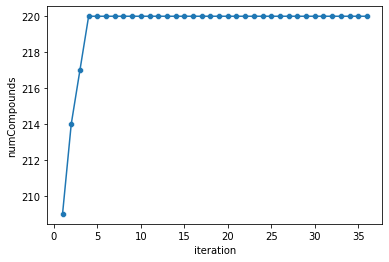

In [82]:
sns.lineplot(x='iteration',y='numCompounds', data= pd.DataFrame(rt))
sns.scatterplot(x='iteration',y='numCompounds', data= pd.DataFrame(rt))

In [43]:
#['C00039' in x for x in results['compound_ordering']]

In [109]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
iteration = 0
if iteration > 0:
    c = [x for x in results['compound_ordering'][iteration] if x not in results['compound_ordering'][iteration-1]]
else:
    c =  results['compound_ordering'][iteration]
    
metabolism.compounds[metabolism.compounds.cid.isin(c)]

,cid,formula,name,num_rgroup,electrons
0,C00001,H2O,H2O; Water,0,10.0
8,C00009,H3PO4,Orthophosphate; Phosphate; Phosphoric acid; Or...,0,50.0
10,C00011,CO2,CO2; Carbon dioxide,0,22.0
13,C00014,NH3,Ammonia; NH3,0,10.0
21,C00022,C3H4O3,Pyruvate; Pyruvic acid; 2-Oxopropanoate; 2-Oxo...,0,46.0
...,...,...,...,...,...
4586,C06217,C36H62O31,Cellohexaose,0,526.0
4587,C06218,C30H52O26,Cellopentaose,0,440.0
4588,C06219,C18H32O16,Cellotriose,0,268.0
4610,C06255,C5H8O3,2-Oxopentanoic acid; 2-Oxovalerate; 2-Oxopenta...,0,62.0


In [50]:
import pickle

with open('cath_fold_order.Thermo.19Jan2020.v0.pkl', 'wb') as output:
    pickle.dump(results, output, pickle.HIGHEST_PROTOCOL)

In [47]:
#
import matplotlib.pyplot as plt

Text(0, 0.5, 'number of compounds')

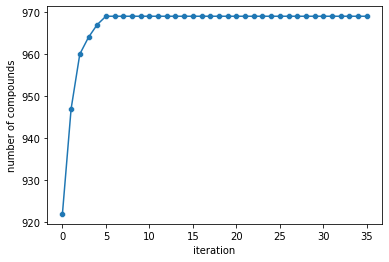

In [48]:
sns.lineplot(y=[len(x) for x in compound_order],x = range(0,len(compound_order)))
sns.scatterplot(y=[len(x) for x in compound_order],x = range(0,len(compound_order)))

plt.xlabel('iteration')
plt.ylabel('number of compounds')

In [52]:
import random

In [56]:
cath_codes_perm = cath_codes.copy()
random.shuffle(cath_codes_perm)

In [57]:
cath_codes_perm

['2.170',
 '3.15',
 '1.50',
 '2.160',
 '2.150',
 '2.110',
 '2.10',
 '3.50',
 '3.40',
 '3.60',
 '2.20',
 '2.60',
 '2.102',
 '2.80',
 '3.30',
 '2.130',
 '3.80',
 '2.140',
 '2.115',
 '3.55',
 '2.120',
 '3.75',
 '3.20',
 '4.10',
 '2.40',
 '3.90',
 '6.10',
 '1.10',
 '2.30',
 '2.70',
 '6.20',
 '3.10',
 '3.70',
 '3.65',
 '1.25',
 '1.20']

In [61]:
fold_set = set()
cpd_set = set(seed_set)
cpd_num = []

for cath in cath_codes_perm:
    fold_set = fold_set.union(set([cath]))
    
    rxns = folds2rn(rules,fold_set)
    # prune network 
    m = metabolism.copy()
    # only keep reactions
    m.subnetwork(rxns)
    if len(m.network) > 0:
        cpds,rxns= m.expand(list(cpd_set))
        cpd_set = cpd_set.union(set(cpds))

    cpd_num.append(len(cpd_set))
    print('done with cath: ' + cath)

/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 2.170


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 3.15


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 1.50


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 2.160


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 2.150


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 2.110


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 2.10


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 3.50


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 3.40


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 3.60


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 2.20


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 2.60


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 2.102


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 2.80


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 3.30


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 2.130


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 3.80


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 2.140


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 2.115


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 3.55


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 2.120


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 3.75


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 3.20


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 4.10


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 2.40


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 3.90


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 6.10


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 1.10


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 2.30


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 2.70


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 6.20


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 3.10


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 3.70


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 3.65


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


done with cath: 1.25
done with cath: 1.20


/Users/joshuagoldford/Documents/github/networkExpansionPy/networkExpansionPy/lib.py:181: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  x,y = netExp(R,P,x0,b)


<AxesSubplot:>

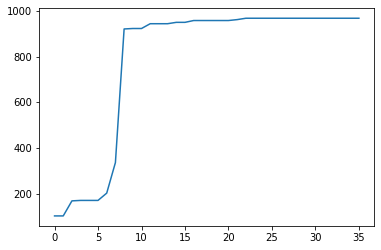

In [62]:
sns.lineplot(x=range(0,len(cpd_num)),y=cpd_num)